##### Описание:
Классифицировать игроков в каждом кадре по двум командам на основе цвета их формы.

### Данные:
Скачайте архив с данными [отсюда](https://disk.yandex.ru/d/NMlVHytktlzbEw) и распакуйте. Внутри архива лежит папка `frames` и файл `bboxes.json`. Файл `bboxes.json` содержит bounding boxes игроков двух команд, а в папке `frames` расположены соответствующие им изображения (кадры). Всего дано 100 кадров. Каждому кадру соответствует 10 bounding boxes игроков.

Структура файла `bboxes.json` следующая:
```
frame_n: {
     player_1: {
             'box': [x,y,w,h],
             'team': int
     }
     .....
     plyaer_10: { .... }
}
....
frame_n+k: { .... }
```
Здесь `frame_n` - номер кадра (ему соответствует файл с изображением в папке frames, всего 100),<br>
`player_1` - id игрока в текущем кадре,<br>
`'box': [x,y,w,h]` - bounding box соответствующего игрока (координаты нормализованы от 0 до 1, поэтому их нужно домножить на размеры изображения, чтобы перевести их в целые координаты фрейма),<br>
`'team': int` - id команды к которой принадлежит игрок  в данном кадре (может принимать значения 0 или 1).
Такм образом, id игроков и id команд имеют смысл только в пределах одного кадра и не связаны с другими кадрами. Т.е. в разных кадрах одному и тому же игроку / команде может соответствовать разные id.

### Задачи:
1) Классифицируйте игроков, используя в качестве вектора признаков игрока (features) средний цвет в пространстве RGB, который берется из области изображения, покрытой bounding box этого игрока (т.е. вектор признаков будет состоять из 3 элементов `[r,g,b]`.<br>
2) Используйте в качестве вектора признаков игроков их средний цвет в пространстве HSV (аналогично вектор признаков `[h,s,v]`.<br>
3) Используйте в качестве вектора признаков гистограмму в пространстве RGB, а не средний цвет. Число бинов определите самостоятельно.<br>
4) Используйте в качестве вектора признаков гистограмму в пространстве HSV.

### Как классифицировать:
В качестве классификатора можете использовать:
- Методы без обучения: k-means (на 2 кластера) или другие методы кластеризации.
- Методы с обучением: K-Nearest Neighbors, RandomForest, GaussianNB или др.

### Результаты:
1. Посчитайте точность классификации для каждого варианта и сравните результаты. 
2. Задание будет принято, если итоговая точность будет выше чем 0.5
3. [опционально] При тестировании на закрытой выборке в конце курса будет подведен итог (рекорд по всем курсам на данный момент - ***0.953***).

#### Полезные советы
- Боксы игроков имеют разный размер, поэтому нормализуйте гистограмму перед ее использованием в качестве вектора признаков (делите значения гистограммы на площадь бокса). 
- Большое число бинов гистограммы может привести к худшим результатам, поэтому попробуйте использовать 8/16/32.
- Для построения вектора признаков лучше использовать некоторую его центральную область, т.к. она покрывает игрока, а границы часто содержут фон / других игроков.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster as sk
import cv2
import json
import os

# Задача №1

### Обявление функция

In [54]:
# Распарсить json-файла
def parsing_json(json_file):
    # Загрузил json
    with open(json_file, 'r') as file:
        data = json.load(file)

        # Перевод в int номер кадра и номер игрока
        data = {
            int(frame_id): {
                int(player_id): info
                for player_id, info in player_id.items()
            }
        for frame_id, player_id in data.items()
        }

        # Перевод bounding_box в [x_min, y_min, w, h]
        for frame_id in data:
            for player_id in data[frame_id]:
                frame = cv2.imread(f'team_classification_data/frames/{frame_id}.jpeg',-1)
                
                x = data[frame_id][player_id]['box'][0] * frame.shape[1]
                y = data[frame_id][player_id]['box'][1] * frame.shape[0]
                w = data[frame_id][player_id]['box'][2] * frame.shape[1]
                h = data[frame_id][player_id]['box'][3] * frame.shape[0]

                data[frame_id][player_id]['box'][0] = int(round(x))
                data[frame_id][player_id]['box'][1] = int(round(y))
                data[frame_id][player_id]['box'][2] = int(round(w))
                data[frame_id][player_id]['box'][3] = int(round(h))
    return data

def get_average_color_in_rgb(img):
    # Разделение на каналы
    r, g, b = cv2.split(img)
    # Расчет средних значений
    avg_r, avg_g, avg_b = np.mean(r), np.mean(g), np.mean(b)
    avg_color = [avg_r, avg_g, avg_b]
    return avg_color

def get_rbg_from_path(image_path):
    image = cv2.imread(image_path, -1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def extract_features_from_frame(frame_data, cv_image):
    features = []
    for player_data in frame_data.values():
        bbox = player_data['box']
        x, y, w, h = bbox
        # Выбираем серидину бб
        w_25 = int(w/4)
        h_25 = int(h/4)
        x = x + w_25
        y = y + h_25
        # Обрезаем изображение по bounding box
        cropped_image = cv_image[y:y + (h_25*2), x:x + (w_25*2)]
        # Преобразуем в массив numpy и вычисляем средний цвет
        avg_color = get_average_color_in_rgb(cropped_image)
        #print(avg_color)
        features.append(avg_color)
    return features


In [ ]:
# Получение данных для обработки
data = parsing_json('team_classification_data/bboxes.json')

### Проверка на коректность выбора bounding box

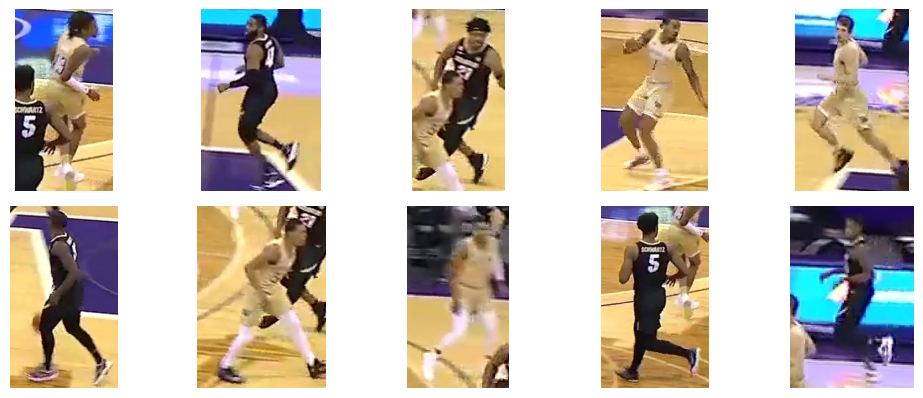

In [56]:
frame = 1577 # фрейм из выборки
img = cv2.imread(f'team_classification_data/frames/{frame}.jpeg',-1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))

for player_id in data[frame]:
    x_min = data[frame][player_id]['box'][0] # x
    y_min = data[frame][player_id]['box'][1] # y
    x_max = x_min + data[frame][player_id]['box'][2] # x+w
    y_max = y_min + data[frame][player_id]['box'][3] # y+h

    img_bbox = img[y_min:y_max, x_min:x_max]
    plt.subplot(5, 5, player_id+1)
    plt.imshow(img_bbox)
    plt.axis('off')

plt.tight_layout()
plt.show()

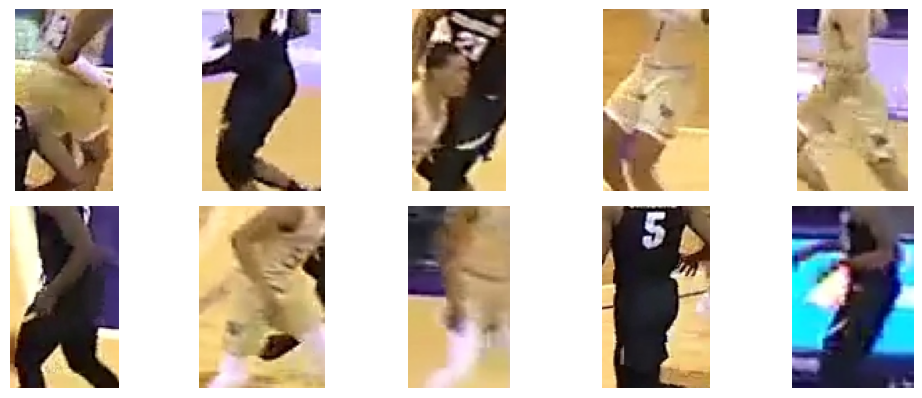

In [57]:
frame = 1577 # фрейм из выборки
img = cv2.imread(f'team_classification_data/frames/{frame}.jpeg',-1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))

for player_id in data[frame]:
    w_25 = int(data[frame][player_id]['box'][2]/4) # 25% ширины бб
    h_25 = int(data[frame][player_id]['box'][3]/4) # 25% высоты бб

    x_min = data[frame][player_id]['box'][0]+w_25 # x
    y_min = data[frame][player_id]['box'][1]+h_25 # y
    x_max = x_min + w_25*2
    y_max = y_min + h_25*2
    # x_max = x_min + data[frame][player_id]['box'][2] # x+w
    # y_max = y_min + data[frame][player_id]['box'][3] # y+h

    img_bbox = img[y_min:y_max, x_min:x_max]
    plt.subplot(5, 5, player_id+1)
    plt.imshow(img_bbox)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Обучение модели k-means

In [ ]:
all_features = []

# Извлечение вектора признаков из bounding box`в всех фреймов
for frame_id, frame_data in data.items():
    features = []
    image_path = f'team_classification_data/frames/{frame_id}.jpeg'
    # Получаю изображение
    image = get_rbg_from_path(image_path)
    # Получаю вектор-признаков
    features = extract_features_from_frame(frame_data, image)
    # Добавляю в общий список векторов-признаков
    all_features.extend(features)

# Обучение k-means
kmeans = sk.KMeans(n_clusters=2)
kmeans.fit(all_features)


KMeans(n_clusters=2)

### Создание Ground Truth словаря

In [ ]:
gt = {}

for frame_id, players in data.items():
    # Инициализируем структуру для текущего кадра
    gt[frame_id] = {"team_0": [], "team_1": []}
    # Распределяем игроков по командам
    for player_id, player_info in players.items():
        team = player_info["team"]
        team_key = f"team_{team}"
        gt[frame_id][team_key].append(player_id)

#print(gt)


{1310: {'team_0': [0, 1, 2, 4, 7, 8], 'team_1': [3, 5, 6, 9]}, 1577: {'team_0': [0, 3, 4, 6, 7, 9], 'team_1': [1, 2, 5, 8]}, 2306: {'team_0': [0, 2, 4, 7, 8], 'team_1': [1, 3, 5, 6, 9]}, 2825: {'team_0': [1, 3, 6, 8, 9], 'team_1': [0, 2, 4, 5, 7]}, 3155: {'team_0': [0, 4, 6, 7], 'team_1': [1, 2, 3, 5, 8, 9]}, 5756: {'team_0': [0, 2, 5, 6, 7, 9], 'team_1': [1, 3, 4, 8]}, 5820: {'team_0': [0, 1, 2, 3, 4, 6], 'team_1': [5, 7, 8, 9]}, 6123: {'team_0': [0, 1, 3, 5, 6], 'team_1': [2, 4, 7, 8, 9]}, 6130: {'team_0': [0, 1, 3, 5, 6], 'team_1': [2, 4, 7, 8, 9]}, 6180: {'team_0': [0, 1, 3, 4, 6], 'team_1': [2, 5, 7, 8, 9]}, 7486: {'team_0': [0, 2, 4, 5, 7], 'team_1': [1, 3, 6, 8, 9]}, 14063: {'team_0': [0, 2, 3, 6, 7], 'team_1': [1, 4, 5, 8, 9]}, 16117: {'team_0': [1, 3, 5, 6, 9], 'team_1': [0, 2, 4, 7, 8]}, 19500: {'team_0': [1, 2, 3], 'team_1': [0, 4, 5, 6, 7, 8, 9]}, 21728: {'team_0': [0, 1, 4, 5, 6, 7], 'team_1': [2, 3, 8, 9]}, 21775: {'team_0': [0, 1, 3, 4, 7, 9], 'team_1': [2, 5, 6, 8]}, 22

### Создание Predicted словаря

In [ ]:
predicted = {}

for frame_id, players in data.items():
    # Инициализируем структуру для текущего кадра
    predicted[frame_id] = {"team_0": [], "team_1": []}
    # Распределяем игроков по командам
    pass

In [ ]:

# Классификация игроков
classified_frames = {}
idx = 0
for frame_id, num_players in data.items():
    predict = kmeans.labels_[idx:idx + num_players]  # Метки кластеров для игроков
    classified_frames[frame_id] = predict.tolist()  # Сохраняем метки для текущего кадра
    start_idx += num_players

print("\nКлассификация игроков по кадрам:")
for frame_id, labels in classified_frames.items():
    print(f"Кадр {frame_id}:")
    print(f"  Предсказанные метки: {labels}")
    print(f"  Ground Truth: {ground_truth[frame_id]}")
    
# Подсчет accuracy
accuracies = []
frame_ids = []

for frame_id, labels in classified_frames.items():
    true_labels = ground_truth[frame_id]
    
    # Создаем матрицу соответствия между предсказанными и истинными метками
    unique_true = sorted(set(true_labels) - {-1})
    unique_pred = sorted(set(labels))
    cost_matrix = np.zeros((len(unique_pred), len(unique_true)))
    for i, pred in enumerate(unique_pred):
        for j, true in enumerate(unique_true):
            cost_matrix[i, j] = -np.sum((np.array(labels) == pred) & (np.array(true_labels) == true))
    
    # Решаем задачу назначения для сопоставления меток
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = {unique_pred[r]: unique_true[c] for r, c in zip(row_ind, col_ind)}
    
    # Перемаппим предсказанные метки
    mapped_labels = [mapping[label] for label in labels]
    
    # Вычисляем accuracy
    accuracy = accuracy_score(true_labels, mapped_labels)
    accuracies.append(accuracy)
    frame_ids.append(frame_id)
    #print(f"Кадр {frame_id}: Точность = {accuracy:.2f}")

# Построение графика точности
plt.figure(figsize=(10, 6))
plt.plot(frame_ids, accuracies, marker='o', linestyle='-', color='b')
plt.title("Точность классификации игроков по кадрам")
#plt.xlabel('off')
plt.ylabel("Точность")
plt.ylim(0, 1.1)  # Ограничение по оси Y от 0 до 1
plt.grid(True)
plt.tight_layout()
plt.show()